In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)
# https://stackoverflow.com/questions/24350859/latex-font-style-issues-using-amsmath-and-sfmath-for-plot-labeling

from scipy.stats import bernoulli
from scipy.special import loggamma

from sklearn.preprocessing import OneHotEncoder

import tqdm

from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

In [2]:
import os
import pickle

In [3]:
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000

In [4]:
from functools import lru_cache

@lru_cache(maxsize = 10000)
def normterm_discrete(n, k):
    if n == 1:
        return np.log(k)
    if k == 1:
        return 1.0
    elif k == 2:
        return np.sum(sorted([ np.exp(loggamma(n+1) - loggamma(t+1) - loggamma(n-t+1) + 
                               t*(np.log(t) - np.log(n)) + (n-t)*(np.log(n-t) - np.log(n))
                        )
                        for t in range(1, n)]))
    else:
        return normterm_discrete(n, k-1) + n/(k-2) * normterm_discrete(n, k-2)

In [5]:
def calc_dnml(X, Z1, Z2, K=3, L=3):    
    N = X.shape[0]
    
    codelen_x_z = 0.0
    codelen_z = 0.0

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                codelen_x_z += n_all * np.log(n_all)
                codelen_x_z += np.log(normterm_discrete(n_all, 2))
                
            if n_pos >=2:
                codelen_x_z -= n_pos * np.log(n_pos)
            if n_neg >=2:
                codelen_x_z -= n_neg * np.log(n_neg)
            
        n_k = np.sum(Z1 == k)
        if n_k >= 1:
            codelen_z += n_k * (np.log(N) - np.log(n_k))

    codelen_z += np.log(normterm_discrete(N, K))
    
    codelen = codelen_x_z + codelen_z

    return codelen, codelen_x_z, codelen_z

In [6]:
def calc_sc(X, Z1, Z2, K=3, L=3):    
    N = X.shape[0]
    
    sc_x_z = 0.0
    sc_z = 0.0
    
    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                sc_x_z += np.log(normterm_discrete(n_all, 2))

    sc_z += np.log(normterm_discrete(N, K))
    
    return sc_x_z, sc_z

In [7]:
def calc_lsc(X, Z1, Z2, K=3, L=3):    
    codelen = 0.0
    N = X.shape[0]

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                codelen += n_all * np.log(n_all)
            
            if n_pos >=2:
                codelen -= n_pos * np.log(n_pos)
            if n_neg >=2:
                codelen -= n_neg * np.log(n_neg)

        n_k = np.sum(Z1 == k)
        if  n_k >= 1:
            codelen += n_k * (np.log(N) - np.log(n_k))

        codelen += (k + (k+1)*(k+2))/2 * np.log(N/(2.0*np.pi)) -(k+1)/2 * np.log(2.0) + \
           (k+1) * loggamma((k+3)/2) - loggamma((k+1)*(k+3)/2) + (k+1)*(k+2)/2 * np.log(np.pi)

    return codelen

In [8]:
def calc_stats(X, z, 
               scores, scores_f, scores_l, h, delta, K=10):
    scores = np.array(scores)
    scores_f = np.array(scores_f)
    scores_l = np.array(scores_l)
    
    N_trial = scores.shape[0]
    T = scores.shape[1] + 2*h
    K = scores.shape[2]
    
    codelens = np.array([ codelen_integer(k) for k in range(1, K+1)])
    
    idxes_all = np.nanargmin(scores + np.tile(codelens[np.newaxis, np.newaxis], (N_trial, T, 1))[0, 0, :], axis=2)
    
    idxes_all = np.hstack((np.nan * np.ones((idxes_all.shape[0], h)), 
                           idxes_all, 
                           np.nan * np.ones((idxes_all.shape[0], h))))
    
    models_estimated = np.nan * np.ones((N_trial, T), dtype=np.float)
    models_former = np.nan * np.ones((N_trial, T), dtype=np.float)
    models_latter = np.nan * np.ones((N_trial, T), dtype=np.float)
    stats_complete = np.nan * np.ones((N_trial, T), dtype=np.float)
    
    for trial in range(N_trial):
        n_change = 0  # number of changes so far.
        for t in range(h, T-h):
            alpha= (n_change+1/2) / (t+1+1)
            m_estimated = int(idxes_all[trial, t])
            
            # estimated blocks
            z_t = np.argmax(z[trial][t][m_estimated], axis=1)

            # stochastic complexity
            sc_x_z, sc_z = calc_sc(X[trial, t, :, :], z_t, z_t, m_estimated+1, m_estimated+1)
            # threshold for model change
            eps_M = (sc_x_z + sc_z + codelen_integer(m_estimated+1) - np.log(delta)) / (2.0*h)
            
            # Lv.3 change (Model change)
            stats_half_t = np.zeros((K, K), dtype=np.float)
            for k1 in range(K):
                stats_former = scores_f[trial, t-h, k1]
                for k2 in range(K):
                    if k1 == k2:
                        p = 1.0 - alpha
                    else:
                        p = alpha/(K-1)
                    stats_latter = scores_l[trial, t-h, k2]
                    stats_half_t[k1, k2] = (stats_former + stats_latter) + codelens[k1] - np.log(p)
            m_former_estimated, m_latter_estimated = np.unravel_index(np.nanargmin(stats_half_t), (K, K))
            models_former[trial, t] = m_former_estimated
            models_latter[trial, t] = m_latter_estimated
            
            stat = 0.5 / h *(scores[trial, t-h, m_estimated] + codelens[m_estimated] - stats_half_t[m_former_estimated, m_latter_estimated])
            stats_complete[trial, t] = stat
            
            
            if (t >= 1) & (stat >= eps_M):
                n_change += 1
            models_estimated[trial, t] = m_estimated   
        
    return stats_complete, models_estimated, models_former, models_latter

In [9]:
def calc_stats_with_modelidx(scores, scores_f, scores_l, idxes_model, idxes_model_f, idxes_model_l, h):
    scores = np.array(scores)
    scores_f = np.array(scores_f)
    scores_l = np.array(scores_l)
 
    N_trial = scores.shape[0]
    T = scores.shape[1] + 2*h
    K = scores.shape[2]
        
    stats_complete = np.nan * np.ones((N_trial, T), dtype=np.float)
    
    for trial in range(N_trial):
        for t in range(h, T-h):
            k_estimated_whole = int(idxes_model[trial, t])
            k_estimated_former = int(idxes_model_f[trial, t])
            k_estimated_latter = int(idxes_model_l[trial, t])
            stat = 0.5/h * (scores[trial, t-h, k_estimated_whole] - \
                            (scores_f[trial, t-h, k_estimated_former] + \
                            scores_l[trial, t-h, k_estimated_latter] ))
            stats_complete[trial, t] = stat
            
    return stats_complete

In [10]:
def codelen_integer(k):
    codelen = np.log(2.865)
    while k >= 0.0:
        codelen += k
        k = np.log(k)
        
    return codelen

In [11]:
indir = './data'
outdir = './output'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [12]:
with open(os.path.join(indir, 'X_gradual.pkl'), 'rb') as f:
    X_all = pickle.load(f)

In [13]:
with open(os.path.join(indir, 'Z_gradual.pkl'), 'rb') as f:
    Z_true_all = pickle.load(f)
    
with open(os.path.join(outdir, 'z_gradual.pkl'), 'rb') as f:
    Z_est_all = pickle.load(f)

In [14]:
h = 2

with open(os.path.join(outdir, 'dnml_all_h' + str(h) + '.pkl'), 'rb') as f:
    dnml_all = pickle.load(f)
    
with open(os.path.join(outdir, 'dnml_f_h' + str(h) + '.pkl'), 'rb') as f:
    dnml_f = pickle.load(f)
    
with open(os.path.join(outdir, 'dnml_l_h' + str(h) + '.pkl'), 'rb') as f:
    dnml_l = pickle.load(f)
    
with open(os.path.join(outdir, 'nml_x_z_all_h' + str(h) + '.pkl'), 'rb') as f:
    nml_x_z_all = pickle.load(f)
    
with open(os.path.join(outdir, 'nml_x_z_f_h' + str(h) + '.pkl'), 'rb') as f:
    nml_x_z_f = pickle.load(f)
    
with open(os.path.join(outdir, 'nml_x_z_l_h' + str(h) + '.pkl'), 'rb') as f:
    nml_x_z_l = pickle.load(f)

with open(os.path.join(outdir, 'nml_z_all_h' + str(h) + '.pkl'), 'rb') as f:
    nml_z_all = pickle.load(f)
    
with open(os.path.join(outdir, 'nml_z_f_h' + str(h) + '.pkl'), 'rb') as f:
    nml_z_f = pickle.load(f)
    
with open(os.path.join(outdir, 'nml_z_l_h' + str(h) + '.pkl'), 'rb') as f:
    nml_z_l = pickle.load(f)

In [15]:
dnml_all = dnml_all[np.any(~np.isnan(dnml_all), axis=2), :].reshape(dnml_all.shape[0], dnml_all.shape[1]-2*h, dnml_all.shape[2])
dnml_f = dnml_f[np.any(~np.isnan(dnml_f), axis=2), :].reshape(dnml_f.shape[0], dnml_f.shape[1]-2*h, dnml_f.shape[2])
dnml_l = dnml_l[np.any(~np.isnan(dnml_l), axis=2), :].reshape(dnml_l.shape[0], dnml_l.shape[1]-2*h, dnml_l.shape[2])

In [16]:
nml_x_z_all = nml_x_z_all[np.any(~np.isnan(nml_x_z_all), axis=2), :].reshape(nml_x_z_all.shape[0], nml_x_z_all.shape[1]-2*h, nml_x_z_all.shape[2])
nml_x_z_f = nml_x_z_f[np.any(~np.isnan(nml_x_z_f), axis=2), :].reshape(nml_x_z_f.shape[0], nml_x_z_f.shape[1]-2*h, nml_x_z_f.shape[2])
nml_x_z_l = nml_x_z_l[np.any(~np.isnan(nml_x_z_l), axis=2), :].reshape(nml_x_z_l.shape[0], nml_x_z_l.shape[1]-2*h, nml_x_z_l.shape[2])

In [17]:
nml_z_all = nml_z_all[np.any(~np.isnan(nml_z_all), axis=2), :].reshape(nml_z_all.shape[0], nml_z_all.shape[1]-2*h, nml_z_all.shape[2])
nml_z_f = nml_z_f[np.any(~np.isnan(nml_z_f), axis=2), :].reshape(nml_z_f.shape[0], nml_z_f.shape[1]-2*h, nml_z_f.shape[2])
nml_z_l = nml_z_l[np.any(~np.isnan(nml_z_l), axis=2), :].reshape(nml_z_l.shape[0], nml_z_l.shape[1]-2*h, nml_z_l.shape[2])

In [18]:
delta = 0.05

dnml, models_estimated, models_former, models_latter = calc_stats(
    X_all, Z_est_all, dnml_all, dnml_f, dnml_l, h, delta=delta)

nml_x_z = calc_stats_with_modelidx(nml_x_z_all, nml_x_z_f, nml_x_z_l, 
                                   models_estimated, models_former, models_latter, h)
 
nml_z = calc_stats_with_modelidx(nml_z_all, nml_z_f, nml_z_l, 
                                 models_estimated, models_former, models_latter, h)

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [19]:
T = 90
dnml_df = pd.DataFrame(dnml, columns=np.arange(1, T+1).astype(str)).reset_index()
nml_x_z_df = pd.DataFrame(nml_x_z, columns=np.arange(1, T+1).astype(str)).reset_index()
nml_z_df = pd.DataFrame(nml_z, columns=np.arange(1, T+1).astype(str)).reset_index()

In [20]:
dnml_df_melt = dnml_df.melt(id_vars='index')
dnml_df_melt['variable'] = dnml_df_melt['variable'].astype(int)

nml_x_z_df_melt = nml_x_z_df.melt(id_vars='index')
nml_x_z_df_melt['variable'] = nml_x_z_df_melt['variable'].astype(int)

nml_z_df_melt = nml_z_df.melt(id_vars='index')
nml_z_df_melt['variable'] = nml_z_df_melt['variable'].astype(int)

In [21]:
dnml_df_melt['criterion'] = 'DNML'
nml_x_z_df_melt['criterion'] = 'NML (X|Z)'
nml_z_df_melt['criterion'] = 'NML (Z)'

In [22]:
models_estimated_df_melt = pd.DataFrame(models_estimated+1, columns=np.arange(1, T+1).astype(int)).melt()

In [23]:
models_estimated_df_melt['variable'] = models_estimated_df_melt['variable'].astype(np.int)

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


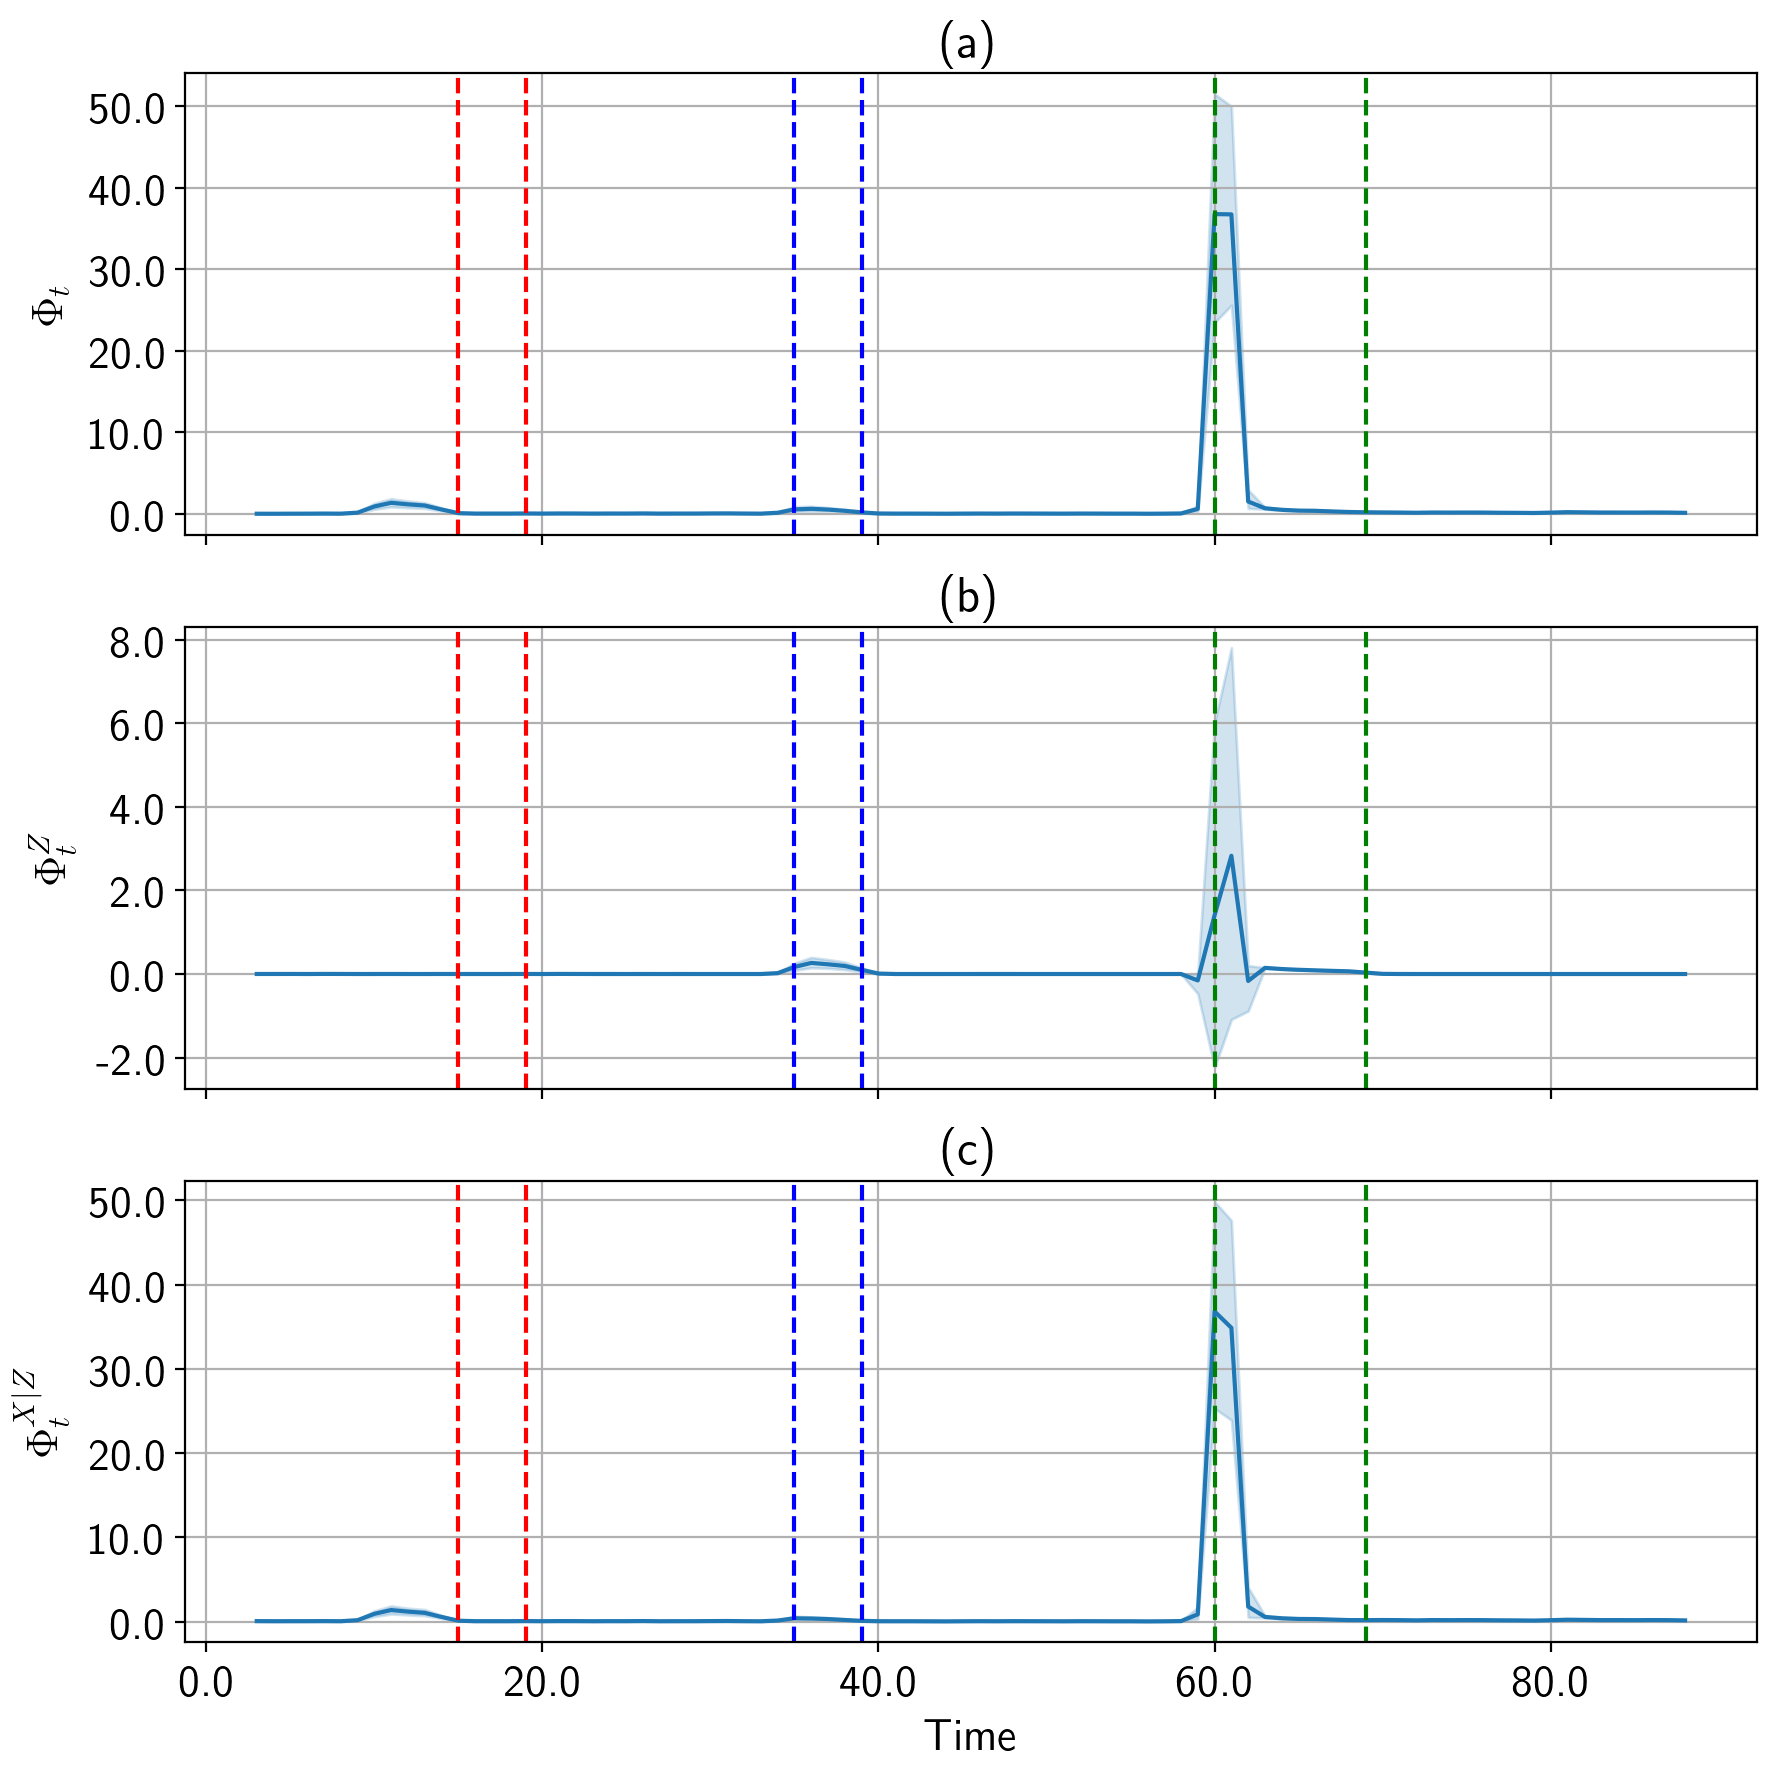

In [24]:
fontsize_title = 18
fontsize = 16

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(9, 9), dpi=200)

#sns.lineplot(x='variable', y='value', data=models_estimated_df_melt, ax=axes[0])
#axes[0].axvline(x=15, color='red', linestyle='dashed')
#axes[0].axvline(x=19, color='red', linestyle='dashed')
#axes[0].axvline(x=35, color='blue', linestyle='dashed')
#axes[0].axvline(x=39, color='blue', linestyle='dashed')
#axes[0].axvline(x=60, color='green', linestyle='dashed')
#axes[0].axvline(x=69, color='green', linestyle='dashed')
#axes[0].grid()
#axes[0].set_title('(a)', fontsize=fontsize_title)
#axes[0].set_xlabel('Time', fontsize=fontsize)
#axes[0].set_ylabel('Estimated \# of blocks', fontsize=fontsize)

sns.lineplot(x='variable', y='value', data=dnml_df_melt, ax=axes[0])
axes[0].axvline(x=15, color='red', linestyle='dashed')
axes[0].axvline(x=19, color='red', linestyle='dashed')
axes[0].axvline(x=35, color='blue', linestyle='dashed')
axes[0].axvline(x=39, color='blue', linestyle='dashed')
axes[0].axvline(x=60, color='green', linestyle='dashed')
axes[0].axvline(x=69, color='green', linestyle='dashed')
axes[0].grid()
axes[0].set_title('(a)', fontsize=fontsize_title)
axes[0].set_xlabel('Time', fontsize=fontsize)
axes[0].set_ylabel(r'$\Phi_{t}$', fontsize=fontsize, rotation=90)

sns.lineplot(x='variable', y='value', data=nml_z_df_melt, ax=axes[1])
axes[1].axvline(x=15, color='red', linestyle='dashed')
axes[1].axvline(x=19, color='red', linestyle='dashed')
axes[1].axvline(x=35, color='blue', linestyle='dashed')
axes[1].axvline(x=39, color='blue', linestyle='dashed')
axes[1].axvline(x=60, color='green', linestyle='dashed')
axes[1].axvline(x=69, color='green', linestyle='dashed')
axes[1].grid()
axes[1].set_title('(b)', fontsize=fontsize_title)
axes[1].set_xlabel('Time', fontsize=fontsize)
axes[1].set_ylabel(r'$\Phi_{t}^{Z}$', fontsize=fontsize)

sns.lineplot(x='variable', y='value', data=nml_x_z_df_melt, ax=axes[2])
axes[2].axvline(x=15, color='red', linestyle='dashed')
axes[2].axvline(x=19, color='red', linestyle='dashed')
axes[2].axvline(x=35, color='blue', linestyle='dashed')
axes[2].axvline(x=39, color='blue', linestyle='dashed')
axes[2].axvline(x=60, color='green', linestyle='dashed')
axes[2].axvline(x=69, color='green', linestyle='dashed')
axes[2].grid()
axes[2].set_title('(c)', fontsize=fontsize_title)
axes[2].set_xlabel('Time', fontsize=fontsize)
axes[2].set_ylabel(r'$\Phi_{t}^{X|Z}$', fontsize=fontsize)

for ax in axes:
    fontProperties = {'family':'sans-serif', 'weight': 'normal', 'size': fontsize}
    ax.set_xticklabels(ax.get_xticks(), fontProperties)
    ax.set_yticklabels(ax.get_yticks(), fontProperties)

fig.tight_layout()

plt.show()